In [24]:
import time
import imutils
import cv2
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

In [25]:
def detect_corner(predictions_align_df):
    predictions_align_df["sum"] = predictions_align_df["xmin"] + predictions_align_df["ymin"]
    index_ = predictions_align_df["sum"].idxmax()
    if index_== 0:
        top_right = (predictions_align_df.xmin[2],predictions_align_df.ymin[2])
        bot_right = (predictions_align_df.xmax[1],predictions_align_df.ymin[1]) 
        bot_left = (predictions_align_df.xmax[0],predictions_align_df.ymax[0]) 
        top_left = (predictions_align_df.xmin[3],predictions_align_df.ymax[3])  
    elif index_ == 1:
        top_left = (predictions_align_df.xmin[3],predictions_align_df.ymin[3])
        top_right = (predictions_align_df.xmax[2],predictions_align_df.ymin[2]) 
        bot_right = (predictions_align_df.xmax[1],predictions_align_df.ymax[1]) 
        bot_left = (predictions_align_df.xmin[0],predictions_align_df.ymax[0]) 
    elif index_ == 2:
        bot_left = (predictions_align_df.xmin[0],predictions_align_df.ymin[0])
        top_left = (predictions_align_df.xmax[3],predictions_align_df.ymin[3]) 
        top_right = (predictions_align_df.xmax[2],predictions_align_df.ymax[2]) 
        bot_right = (predictions_align_df.xmin[1],predictions_align_df.ymax[1]) 
    else:
        bot_right = (predictions_align_df.xmin[1],predictions_align_df.ymin[1])
        bot_left = (predictions_align_df.xmax[0],predictions_align_df.ymin[0]) 
        top_left = (predictions_align_df.xmax[3],predictions_align_df.ymax[3]) 
        top_right = (predictions_align_df.xmin[2],predictions_align_df.ymax[2])   
    arr_corner = np.float32([
        top_left, top_right , bot_right, bot_left
    ]) 
    return arr_corner

In [26]:
def perspective_transform(image, source_points):
    dest_points = np.float32([[0,0], [640,0], [640,480], [0,480]])
    M = cv2.getPerspectiveTransform(source_points, dest_points)
    dst = cv2.warpPerspective(image, M, (640, 480))
    return dst

In [27]:
INVALID_PARAM_MSG = "Invalid parameters"

def exist_file(file_path):
    return os.path.isfile(file_path)

def read_yolo5(path, device_type='cpu'):
    if exist_file(path) == False:
        raise Exception(INVALID_PARAM_MSG)
#     model = torch.hub.load('ultralytics/yolov5', 'custom', path=path,device=device_type)
    model = torch.hub.load('/home/jovyan/work/fingerPrint/yolov5', 'custom', source='local', path=path,device=device_type)
    return model

In [28]:
align_model_path = "/data_science/data_science/data/v1/idcard/data_align/last.pt"
align_model = read_yolo5(align_model_path)

YOLOv5 🚀 v6.1-237-g50b886d Python-3.8.11 torch-1.11.0+cu102 CPU

Fusing layers... 
Model summary: 367 layers, 46124433 parameters, 0 gradients, 107.8 GFLOPs
Adding AutoShape... 


In [29]:
def align_idcard(cv_img):
    cv_img = cv2.resize(cv_img,(640,640))
    
    predictions_align =  align_model(cv_img)
    predictions_align_df = predictions_align.pandas().xyxy[0]
    if len(predictions_align_df) == 4:
        predictions_align_df.sort_values(["class","confidence"],inplace=True,ascending = False)
        predictions_align_df.drop_duplicates("class",inplace=True)
        predictions_align_df.reset_index(drop=True,inplace=True)
        arr_corner = detect_corner(predictions_align_df)
        cv_img = perspective_transform(cv_img, arr_corner)

    cv_img = cv2.resize(cv_img,(640, 480))
    
    return cv_img

In [44]:
cv_img = cv2.imread("/data_science/data_science/data/v1/idcard/bug/image_2022-05-25_09-47-42.png")
cv_img = cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB)
align_img = align_idcard(cv_img)

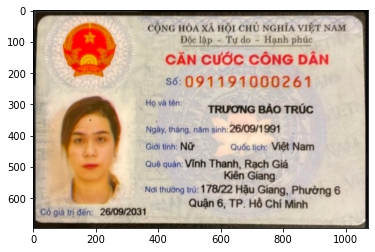

In [45]:
# displaying image
%matplotlib inline

plt.imshow(cv_img)
plt.show()

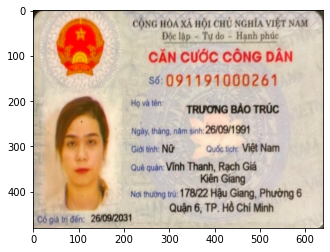

In [46]:
# displaying image
%matplotlib inline

plt.imshow(align_img)
plt.show()